In [1]:
import gym
from gym import Env, spaces

import numpy as np
import seaborn as sns
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

c:\Users\tass\anaconda3\Lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



Configurar o Enxame


In [2]:
num_drones = 9
limite_y = 80
limite_x = 100

alcance_comunicacao_jammer = 25
alcance_comunicacao_nos=500
B_Hz = 2.4e9  # Largura de banda

# Posições estáticas dos drones
posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50],[42, 25], [35, 15], [26, 23]])

posicao_jammer = np.array([80,70])



ENCONTRAR VIZINHOS E NOS AFETADOS

In [3]:
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
# Preparando a figura

def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer

vizinhos = encontra_vizinhos(posicoes, alcance_comunicacao_nos)
afetados_pelo_jammer = verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)

print('Nos Vizinhos:', vizinhos)
print('Nos Afetados Jammer:', afetados_pelo_jammer)

Nos Vizinhos: {0: [1, 2, 3, 4, 5, 6, 7, 8], 1: [0, 2, 3, 4, 5, 6, 7, 8], 2: [0, 1, 3, 4, 5, 6, 7, 8], 3: [0, 1, 2, 4, 5, 6, 7, 8], 4: [0, 1, 2, 3, 5, 6, 7, 8], 5: [0, 1, 2, 3, 4, 6, 7, 8], 6: [0, 1, 2, 3, 4, 5, 7, 8], 7: [0, 1, 2, 3, 4, 5, 6, 8], 8: [0, 1, 2, 3, 4, 5, 6, 7]}
Nos Afetados Jammer: []


CALCULA AS POTENCIAS DE RECEÇÃO

In [4]:
Ptx_dBm = 30 
Gtx_dBi =10
Grx_dBi =10
f = 2.4e9 
B_Hz= 2.4e9
d0=1
gamma=2


def calcular_Prx_dB(Ptx_dBm, Gtx_dBi, Grx_dBi, d,d0,gamma, f):
    """
    Calcula a potência do sinal recebido usando a equação de Friis.
    """
    c = 3e8  # Velocidade da luz em m/s
    lambda_m = c / f  # Comprimento de onda
    L = (4 * np.pi * d / lambda_m)**2
    Prx_dBm = Ptx_dBm + Gtx_dBi + Grx_dBi - 10 * np.log10(L)
    return Prx_dBm


def calcular_potencia_recebida_vizinhos(vizinhos, posicoes):
    prx_resultados = {}
    for drone, seus_vizinhos in vizinhos.items():
        for vizinho in seus_vizinhos:
            d = distancia(posicoes[drone], posicoes[vizinho])
            prx = calcular_Prx_dB(Ptx_dBm, Gtx_dBi, Grx_dBi, d,d0,gamma, f)
            prx_resultados[f"Drone {drone} para Vizinho {vizinho}"] = prx
    return prx_resultados

prx_resultados = calcular_potencia_recebida_vizinhos(vizinhos, posicoes)
print('resultadosPRX',prx_resultados)

# Exibir os resultados
for chave, prx in prx_resultados.items():
    print(f"{chave}: Prx = {prx:.2f} dBm")
    
    




resultadosPRX {'Drone 0 para Vizinho 1': -15.20473545739759, 'Drone 0 para Vizinho 2': -20.084908682649896, 'Drone 0 para Vizinho 3': -22.828959101193533, 'Drone 0 para Vizinho 4': -24.343519820304877, 'Drone 0 para Vizinho 5': -21.966092946817497, 'Drone 0 para Vizinho 6': -18.503177199947373, 'Drone 0 para Vizinho 7': -17.724973180461703, 'Drone 0 para Vizinho 8': -11.77785970440354, 'Drone 1 para Vizinho 0': -15.20473545739759, 'Drone 1 para Vizinho 2': -22.513444117519214, 'Drone 1 para Vizinho 3': -18.175130586709358, 'Drone 1 para Vizinho 4': -21.362183663772058, 'Drone 1 para Vizinho 5': -20.16592816687337, 'Drone 1 para Vizinho 6': -20.479619800492088, 'Drone 1 para Vizinho 7': -21.438489195996866, 'Drone 1 para Vizinho 8': -18.428189239357053, 'Drone 2 para Vizinho 0': -20.084908682649896, 'Drone 2 para Vizinho 1': -22.513444117519214, 'Drone 2 para Vizinho 3': -25.84954363134672, 'Drone 2 para Vizinho 4': -25.315847705880756, 'Drone 2 para Vizinho 5': -21.053147886011615, 'Dr

CALCULAR AS CAPACIDADES

Considero o ruido apenas o efeito dos outros drones que não estão a comunicar diretamente com o meu nó 

Atribuí um peso de apenas 30% da potencia de receção caso o drone estivesse a apontar diretamente

In [6]:
# ganho_maximo_antena_dBi=15
potencia_jammer_dBm =100
ganho_transmissão_jammer=0
HPBW=60
ganho_maximo_antena_dBi=15
def calcular_angulo(pos_drone, orientacao_drone, pos_jammer):
    """
    Calcula o ângulo entre a direção do jammer e a orientação da antena do drone.

    :param pos_drone: Posição do drone (x, y).
    :param orientacao_drone: Orientação do drone em graus (0-360).
    :param pos_jammer: Posição do jammer (x, y).
    :return: Ângulo em graus.
    """
    vetor_drone = np.array([np.cos(np.radians(orientacao_drone)), np.sin(np.radians(orientacao_drone))])
    vetor_jammer = np.array(pos_jammer) - np.array(pos_drone)
    vetor_jammer_normalizado = vetor_jammer / np.linalg.norm(vetor_jammer)
    
    dot_product = np.dot(vetor_drone, vetor_jammer_normalizado)
    angle = np.arccos(dot_product)
    
    return np.degrees(angle)



def calcular_Grx_dBi(angulo, HPBW, max_gain_dBi):
    # Carrega os dados do documento
    ganhos = pd.read_csv("C:/Users/tass/OneDrive - EXÉRCITO PORTUGUÊS/Ambiente de Trabalho/Tese/Simulaçãoes/ganhos.csv")

    # Arredonda e normaliza o ângulo para 0-359
    angulo = round(angulo) % 360

    # Verifique se o ângulo é um índice válido
    if angulo in ganhos.index:
        ganho = ganhos.loc[angulo, "ganho"]
    else:
        raise KeyError(f"O ângulo {angulo} não está no índice do arquivo CSV")

    return ganho

def calcular_capacidade_canal(Prx_dBm, B_Hz, N_dBm):
    """
    Calcula a capacidade do canal usando o teorema de Shannon-Hartley.

    :param Prx_dBm: Potência do sinal recebido em dBm.
    :param B_Hz: Largura de banda do canal em Hertz.
    :param N_dBm: Potência do ruído em dBm.
    :return: Capacidade do canal em bits por segundo.
    """
    k = 1.380649e-23
    # Temperatura padrão em kelvins (290K é comum para cálculos de RF)
    T = 290
    
    if N_dBm == 0:
        # Calcula a densidade espectral de ruído (N_0)
        N0_W_Hz = k * T
        # Calcula a potência do ruído térmico em watts
        N_W = N0_W_Hz * B_Hz
        # Converte a potência do ruído térmico para dBm
        N_dBm = 10 * np.log10(N_W / 0.001)
    # Convertendo potências de dBm para Watts
    Prx_W = 10**((Prx_dBm - 30) / 10)
    N_W = 10**((N_dBm - 30) / 10)

    # Calculando a razão sinal-ruído (SNR)
    SNR = Prx_W / N_W
    # print(SNR)

    # Calculando a capacidade do canal 
    C_bps = B_Hz * np.log2(1 + SNR)
    
    return C_bps



def calcular_potencia_ruido_jammer(angulo, potencia_jammer_dBm, HPBW, ganho_maximo_antena_dBi,d):
    c = 3e8  # Velocidade da luz em m/s
    lambda_m = c / f  # Comprimento de onda
    L = (4 * np.pi * d / lambda_m)**2
    Ptx_dBm=potencia_jammer_dBm
    Gtx_dBi=ganho_transmissão_jammer
    Grx_dBi=calcular_Grx_dBi(angulo,HPBW,ganho_maximo_antena_dBi)
    N_dBm = Ptx_dBm + Gtx_dBi + Grx_dBi - 10 * np.log10(L)
    
    return N_dBm

def calcular_angulo_relativo(pos_drone, pos_vizinho, pos_jammer):
    """
    Calcula o ângulo do jammer em relação à direção do drone para o vizinho, que é a referência de 0º.
    """
    vetor_drone_vizinho = np.array(pos_vizinho) - np.array(pos_drone)
    vetor_drone_jammer = np.array(pos_jammer) - np.array(pos_drone)

    # Normaliza os vetores
    vetor_drone_vizinho = vetor_drone_vizinho / np.linalg.norm(vetor_drone_vizinho)
    vetor_drone_jammer = vetor_drone_jammer / np.linalg.norm(vetor_drone_jammer)

    # Calcula o cosseno do ângulo entre eles
    dot_product = np.dot(vetor_drone_vizinho, vetor_drone_jammer)
    
    # Evita valores fora do domínio da função arccos devido a erros de precisão numérica
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    angulo = np.arccos(dot_product)
    
    # Converte em graus e determina se o ângulo é positivo ou negativo com base no produto vetorial
    angulo = np.degrees(angulo) * np.sign(np.cross(vetor_drone_vizinho, vetor_drone_jammer))
    # Normaliza o ângulo para estar entre 0 e 360
    angulo = angulo % 360
    
    return angulo

def calcular_capacidades_canais(prx_resultados, posicoes):
    # Armazena as capacidades de canal para cada link na rota
    capacidades = []

    for drone, seus_vizinhos in vizinhos.items():
        posicao_drone = posicoes[drone]
        for vizinho in seus_vizinhos:
            posicao_vizinho = posicoes[vizinho]
            chave_prx = f'Drone {drone} para Vizinho {vizinho}'
            
            if chave_prx in prx_resultados:
                Prx_dBm = prx_resultados[chave_prx]
                
                # Calcula o ângulo do jammer em relação à linha drone-vizinho
                angulo_relativo = calcular_angulo_relativo(posicao_drone, posicao_vizinho, posicao_jammer)
                # print (angulo_relativo)
                
                # print(drone,vizinho,angulo_relativo)
                
                # Ajusta o ângulo para a convenção de ângulo da antena
                if angulo_relativo < 0:
                    angulo_relativo += 360
                # print(angulo_relativo)
                
                
                d=distancia(posicoes[drone], posicao_jammer)
                # print('Distancia ao jammer do drone',drone,'ao jammer:',d)
                # Calcula o ruído com base no ganho da antena
                N_dBm = calcular_potencia_ruido_jammer(angulo_relativo, potencia_jammer_dBm, HPBW, ganho_maximo_antena_dBi,d)
                # print(Prx_dBm,N_dBm)
                # Calcular a capacidade do canal
                capacidade_bps = calcular_capacidade_canal(Prx_dBm, B_Hz, N_dBm)
                capacidade_bps /= 1e6  # Convertendo para Mbps
                capacidades.append((drone, vizinho, capacidade_bps))

    return capacidades



capacidades = calcular_capacidades_canais(prx_resultados, posicoes)

bottleneck_bps = float('inf')

# Identificar a capacidade mais baixa ao longo da rota
for transmissor, receptor, capacidade_bps in capacidades:
    print(f"Capacidade do canal entre Drone {transmissor} e Drone {receptor}: {capacidade_bps:.2f} Mbps")
    if capacidade_bps < bottleneck_bps:
        bottleneck_bps = capacidade_bps

# Verifica se um bottleneck foi encontrado
if bottleneck_bps < float('inf'):
    print(f"O bottleneck da rota é: {bottleneck_bps:.2f} Mbps")
else:
    print("Não foi possível determinar o bottleneck.")


capacidade_dict = {(transmissor, receptor): capacidade_bps for transmissor, receptor, capacidade_bps in capacidades}

print(capacidade_dict)

Capacidade do canal entre Drone 0 e Drone 1: 0.43 Mbps
Capacidade do canal entre Drone 0 e Drone 2: 0.35 Mbps
Capacidade do canal entre Drone 0 e Drone 3: 0.05 Mbps
Capacidade do canal entre Drone 0 e Drone 4: 0.01 Mbps
Capacidade do canal entre Drone 0 e Drone 5: 0.01 Mbps
Capacidade do canal entre Drone 0 e Drone 6: 0.08 Mbps
Capacidade do canal entre Drone 0 e Drone 7: 1.61 Mbps
Capacidade do canal entre Drone 0 e Drone 8: 4.70 Mbps
Capacidade do canal entre Drone 1 e Drone 0: 10.94 Mbps
Capacidade do canal entre Drone 1 e Drone 2: 0.45 Mbps
Capacidade do canal entre Drone 1 e Drone 3: 0.37 Mbps
Capacidade do canal entre Drone 1 e Drone 4: 0.02 Mbps
Capacidade do canal entre Drone 1 e Drone 5: 0.02 Mbps
Capacidade do canal entre Drone 1 e Drone 6: 0.32 Mbps
Capacidade do canal entre Drone 1 e Drone 7: 1.65 Mbps
Capacidade do canal entre Drone 1 e Drone 8: 9.70 Mbps
Capacidade do canal entre Drone 2 e Drone 0: 11.10 Mbps
Capacidade do canal entre Drone 2 e Drone 1: 0.45 Mbps
Capacida

VIZUALIZAR O ENXAME

In [ ]:
fig = go.Figure()

# Adiciona os drones
for i in range(num_drones):
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0]],
        y=[posicoes[i, 1]],
        mode='markers+text',
        marker=dict(size=10, color='orange' if i in afetados_pelo_jammer else 'blue'),
        text=str(i),
        textposition="bottom center",
        showlegend=False  # Oculta esses rastros da legenda
    ))

# Adiciona o jammer
fig.add_trace(go.Scatter(
    x=[posicao_jammer[0]],
    y=[posicao_jammer[1]],
    mode='markers',
    marker=dict(size=12, color='red'),
    name='Jammer'
))

# Adiciona rastros para a legenda
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='blue'), name="Nó não afetado"))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='orange'), name="Nó afetado"))
# O Jammer já está adicionado com a legenda correta

# Configurações do gráfico
fig.update_layout(
    title="Simulação de Modelo de Comunicação Wireless entre Drones",
    xaxis=dict(range=[0, limite_x], autorange=False),
    yaxis=dict(range=[0, limite_y], autorange=False),
    legend_title_text='Legenda',
    legend=dict(traceorder='normal', itemsizing='constant')
)

fig.show()

c:\Users\tass\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



OPEN AI GYM

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class UAVCommunicationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=num_drones, area_size=(100, 100)):
        super(UAVCommunicationEnv, self).__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.posicoes = posicoes
        self.posicao_jammer = posicao_jammer
        self.afetados_pelo_jammer=afetados_pelo_jammer
        self.prx_resultados=prx_resultados
        self.B_Hz = B_Hz  # Largura de banda
        self.capacidade_bps = capacidade_dict
        self.ultimo_info = {}
        
        self.ultima_acao = np.zeros(self.num_uavs, dtype=int)
        
        

        self.action_space = spaces.MultiDiscrete([num_uavs] * num_uavs)
        
        # O estado agora inclui somente as direções de comunicação (índices dos UAVs-alvo)
        self.observation_space = spaces.Discrete(num_uavs ** num_uavs)
        
        self.ultima_acao = np.zeros(num_uavs, dtype=int)  # Inicializa com todos os UAVs não comunicando

    def step(self, action):
        # Ajuste de ação para garantir que nenhum drone esteja se comunicando consigo mesmo
        for i in range(self.num_uavs):
            while action[i] == i:
                action[i] = np.random.choice([x for x in range(self.num_uavs) if x != i])

        self.ultima_acao = np.array(action)

        # Recalcular a capacidade mínima e média a partir das ações
        capacidades_selecionadas = []

        for i, destino in enumerate(action):
            chave = (i, destino)
            capacidade = self.capacidade_bps.get(chave, 0)
            capacidades_selecionadas.append(capacidade)

        capacidade_media = np.mean(capacidades_selecionadas) if capacidades_selecionadas else 0
        capacidade_min = np.min(capacidades_selecionadas) if capacidades_selecionadas else 0

        recompensa = 0.4 * capacidade_media + 0.3 * capacidade_min

        done = False  # Indicar se o episódio terminou

        info = {
            'Recompensa': recompensa,
            'capacidade_media': capacidade_media,
            'capacidade_min': capacidade_min,
            'capacidades_selecionadas': capacidades_selecionadas
        }

        self.ultimo_info = info

        return self.ultima_acao, recompensa, done, info

    
    
    def render(self, mode='human'):

        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(9, 4))

        # Desenha os drones no gráfico
        for i, pos in enumerate(self.posicoes):
            color = 'blue'  # Cor padrão para todos os drones
            ax.scatter(pos[0], pos[1], color=color, s=100, label='Drone' if i == 0 else "")
            ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

        # Preparando para coletar capacidades para a legenda
        capacidades_texto = []

        # Desenha as linhas de comunicação e setas
        for i, destino in enumerate(self.ultima_acao):
            if destino != i:  # Evita que um drone se comunique consigo mesmo
                pos_inicio = self.posicoes[i]
                pos_final = self.posicoes[destino]
                ax.plot([pos_inicio[0], pos_final[0]], [pos_inicio[1], pos_final[1]], 'b--', alpha=0.5)

                # Calcula a direção para a seta
                direcao = pos_final - pos_inicio
                direcao_norm = direcao / np.linalg.norm(direcao)
                # Define o comprimento da seta
                comprimento_seta = 5
                ponto_final_seta = pos_inicio + direcao_norm * comprimento_seta

                # Desenha a seta
                ax.arrow(pos_inicio[0], pos_inicio[1], ponto_final_seta[0] - pos_inicio[0], ponto_final_seta[1] - pos_inicio[1], 
                        head_width=2, head_length=2, fc='b', ec='b')

                # Coleta capacidades para a legenda
                capacidade = self.capacidade_bps.get((i, destino), 0)  # Assume 0 se não definido
                capacidades_texto.append(f'Drone {i} para {destino}: {capacidade:.2f} Mbps')

        # Desenha o jammer
        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

        # Adiciona capacidades na legenda
        if capacidades_texto:
            for texto in capacidades_texto:
                ax.plot([], [], ' ', label=texto)

        # Configurações finais do gráfico
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        plt.title('Comunicação UAV com Jammer')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
        plt.show()


def reset(self):
    # Estado inicial
    self.ultima_acao = np.zeros(self.num_uavs, dtype=int)  # Reset action
    
    # Retorna um estado e informações (no caso, informação sobre recompensas e capacidades)
    obs = self.ultima_acao  # Estado inicial
    print('ahahhahaha',obs)
    info = {}  # Garantir que um dicionário vazio seja retornado se `ultimo_info` for None
    
    if self.ultimo_info:
        info.update(self.ultimo_info)  # Se existir, atualiza as informações
    
    return obs, info




    


In [ ]:
# env = UAVCommunicationEnv()

# # Testar a função `reset()`
# state, info = env.reset()  # Deve retornar uma tupla

# print("Estado inicial:", state)
# print("Informações iniciais:", info)  # Verificar se é uma tupla

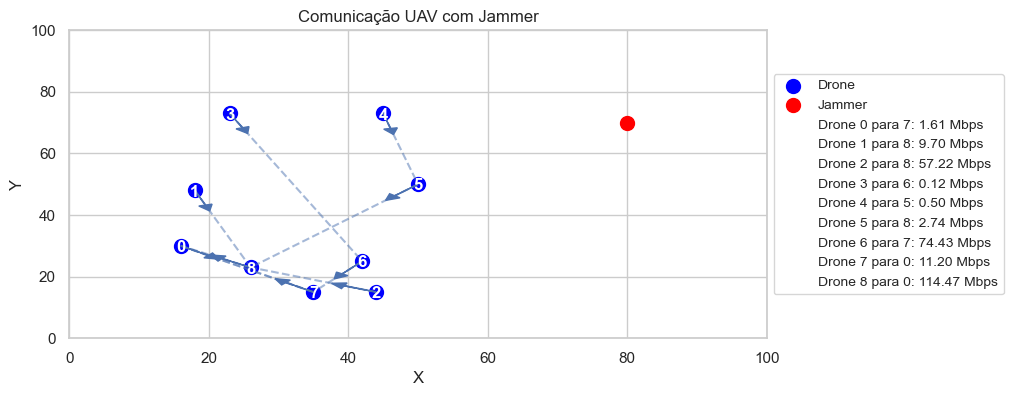

[7 8 8 6 5 8 7 0 0]
{'Recompensa': 12.125458288435341, 'capacidade_media': 30.221028197203207, 'capacidade_min': 0.12349003184686126, 'capacidades_selecionadas': [1.614198381668773, 9.701641769467681, 57.21960767166655, 0.12349003184686126, 0.49792043270810005, 2.7387150766903257, 74.42653866670169, 11.196368351969781, 114.47077339210908]}


In [ ]:
env = UAVCommunicationEnv()

state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Exemplo: escolha uma ação aleatoriamente
    state, reward, done, info = env.step(action)
    env.render()  # Chame render a cada passo para visualizar
    
    print(state)
    print(info)
    done=True


Algoritmo Genético

Generation 0: Best Fitness = 9.95966221047446
Generation 1: Best Fitness = 12.370586574803056
Generation 2: Best Fitness = 13.341240197364332
Generation 3: Best Fitness = 13.439506807331513
Generation 4: Best Fitness = 13.405656102611985
Generation 5: Best Fitness = 14.246905950622372
Generation 6: Best Fitness = 14.279173909022083
Generation 7: Best Fitness = 14.621224738692224
Generation 8: Best Fitness = 14.621224738692224
Generation 9: Best Fitness = 14.635063854948982
Generation 10: Best Fitness = 14.635063854948982
Generation 11: Best Fitness = 15.653944253929428
Generation 12: Best Fitness = 15.653944253929428
Generation 13: Best Fitness = 15.653944253929428
Generation 14: Best Fitness = 15.653944253929428
Generation 15: Best Fitness = 15.653944253929428
Generation 16: Best Fitness = 15.709089258591318
Generation 17: Best Fitness = 15.709089258591318
Generation 18: Best Fitness = 15.709089258591318
Generation 19: Best Fitness = 15.709089258591318
Generation 20: Best Fitness = 15

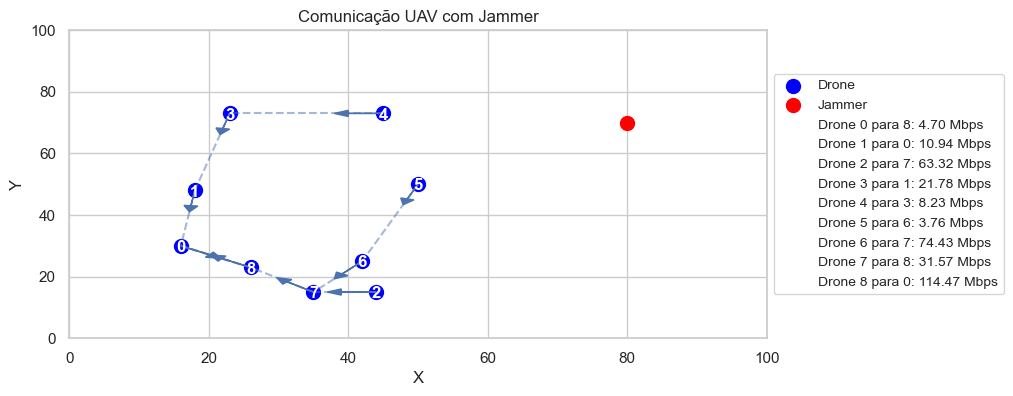

Melhor solução: [8, 0, 7, 1, 3, 6, 7, 8, 0]
Detalhes da melhor solução: {'Recompensa': 15.936028548717397, 'capacidade_media': 37.02210687925056, 'capacidade_min': 3.757285990057243, 'capacidades_selecionadas': [4.704077251780876, 10.94240437436022, 63.31523002824431, 21.77994945544772, 8.228854954278265, 3.757285990057243, 74.42653866670169, 31.573847800275637, 114.47077339210908]}


In [ ]:
import random


class GeneticAlgorithm:
    def __init__(self, env, population_size=50, generations=100, mutation_rate=0.1):
        self.env = env
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = [self.random_chromosome() for _ in range(population_size)]

    def random_chromosome(self):
        return [random.randint(0, self.env.action_space.nvec[i] - 1) for i in range(self.env.num_uavs)]

    def evaluate_fitness(self, chromosome):
        self.env.reset()
        self.env.ultima_acao = chromosome
        _, reward, _, info = self.env.step(chromosome)
        return reward, info

    def select(self):
        tournament_size = 5
        selected = []
        fitness_scores = [self.evaluate_fitness(chromosome) for chromosome in self.population]
        for _ in range(self.population_size):
            contenders = random.sample(list(enumerate(fitness_scores)), tournament_size)
            winner_index, _ = max(contenders, key=lambda item: item[1][0])
            selected.append(self.population[winner_index])
        return selected

    def crossover(self, parent1, parent2):
        point = random.randint(1, self.env.num_uavs - 1)
        return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

    def mutate(self, chromosome):
        for i in range(len(chromosome)):
            if random.random() < self.mutation_rate:
                chromosome[i] = random.randint(0, self.env.action_space.nvec[i] - 1)
        return chromosome

    def run(self):
        best_info = None
        for generation in range(self.generations):
            new_population = []
            parents = self.select()
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(parents, 2)
                child1, child2 = self.crossover(parent1, parent2)
                new_population.extend([self.mutate(child1), self.mutate(child2)])
            self.population = new_population[:self.population_size]
            fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
            best_fitness, best_info = max(fitness_scores, key=lambda x: x[0])
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
        best_solution_index = max(range(len(self.population)), key=lambda i: fitness_scores[i][0])
        best_solution = self.population[best_solution_index]
        return best_solution, best_info

# Inicia o ambiente e o algoritmo genético
env = UAVCommunicationEnv()
ga = GeneticAlgorithm(env)

# Executa o algoritmo e obtém a melhor solução e informações
best_solution, best_info = ga.run()

# Renderiza a melhor solução
env.ultima_acao = best_solution
env.render()

# Imprime informações detalhadas sobre a melhor solução
print("Melhor solução:", best_solution)
print("Detalhes da melhor solução:", best_info)
